In [1]:
%run -i "loaddata.py"
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
np.random.seed(42)

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Choose wisely
save = False
only_2_features=False
test_on = 0
scale = False

In [3]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]) and (vec[:][3:]!=0).any():
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1568, 28)


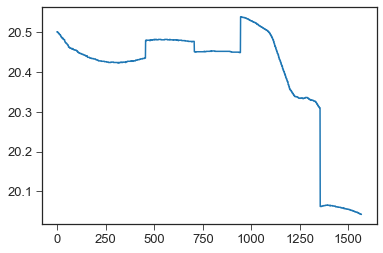

In [4]:
features[8], features[14]
plt.plot(data[:,8])

# All time series in a single plot

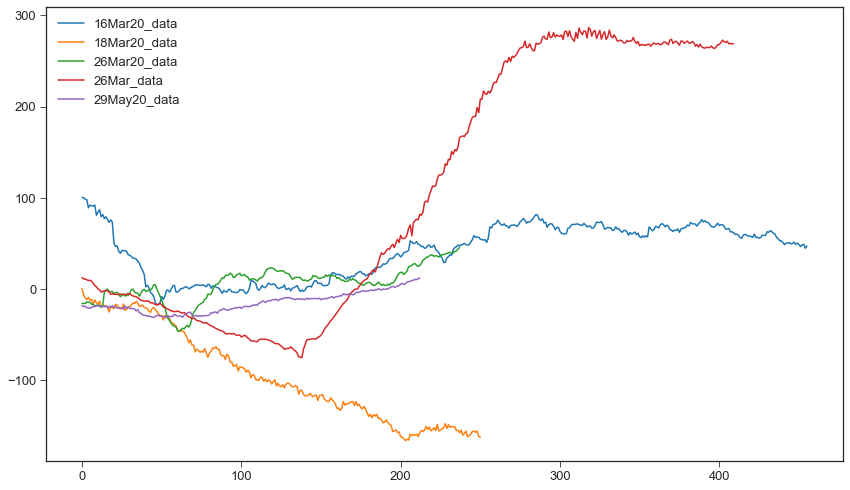

In [5]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure(figsize=(12,7))
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

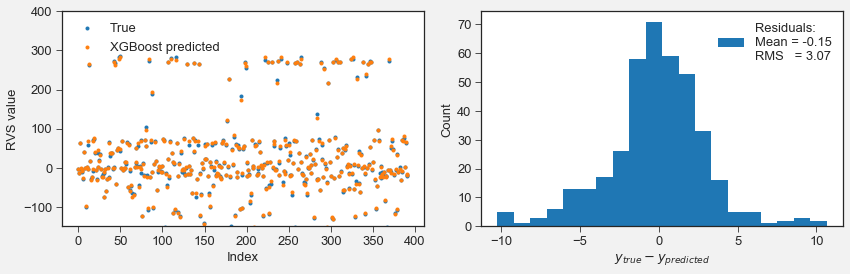

In [7]:
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test, '.',label="True")
plt.plot(y_pred, '.', label="XGBoost predicted")
plt.ylim([-150, 400])
plt.xlabel("Index"); plt.ylabel("RVS value")
plt.legend()

mean = np.mean(y_test - y_pred)
rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))

plt.subplot(122)
plt.hist(y_test-y_pred, label=f"Residuals:\nMean = {mean:.2f}\nRMS   = {rms:.2f}", bins=20)
plt.ylabel("Count"); plt.xlabel("$y_{true} - y_{predicted}$")
plt.legend()
fig.patch.set_facecolor("#f2f2f2")
plt.tight_layout()
plt.show()

In [8]:
# fig.savefig("figs/sklearn_test_split_XGBoost.pdf",facecolor=fig.get_facecolor())

### New Split Shit

In [9]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

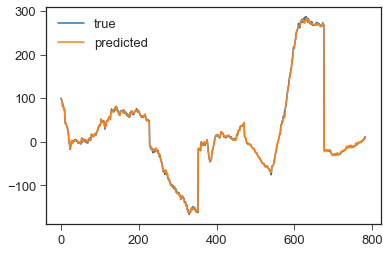

RMS = 2.654


In [10]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [11]:
# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print("Shapes of different timeseries:",[i.shape for i in data_sort])

def test_1_timeseries( test_index , scaler=False):
    X_train = np.empty(( 0, data_sort[0].shape[1]-3))
    y_train = np.array([])
    for i in range(len(data_sort)):
        if i!=test_index:
            if scaler:
                scaler = StandardScaler()
                data_scaled = scaler.fit_transform(data_sort[i])
            else:
                data_scaled = data_sort[i]
            X_train = np.append(X_train, data_scaled[:,3:], axis=0)
            y_train = np.append(y_train, data_scaled[:,1])
    if scaler:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_sort[test_index])
    else: 
        data_scaled = data_sort[test_index]
    X_test = data_scaled[:,3:]
    y_test = data_scaled[:,1]
    return X_train, X_test, y_train, y_test

Shapes of different timeseries: [(456, 28), (247, 28), (238, 28), (407, 28), (211, 28)]


(1103, 25) (456, 25) (1103,) (456,)


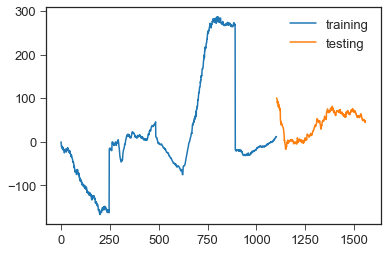

In [12]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=scale)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# # Only two features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]
    print(X_train.shape, X_test.shape)

# Print figure
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGboost

In [13]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [14]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state = 42, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,20),
    "max_depth": st.randint(1,20),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.1s


Random Search: 	Best parameters:  {'learning_rate': 0.040775141554763916, 'max_depth': 4, 'n_estimators': 19} , Best scores: -73.7545


[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.6s finished


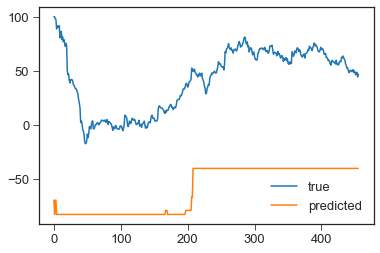

RMS = 102.857


In [15]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Bayesian Optimization

In [16]:
from bayes_opt import BayesianOptimization
def xgboost_CrossValidation(num_round, eta, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=42, 
                                  num_round=num_round,
                                  eta=eta,
                                  max_depth=max_depth)
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_xgboost(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(num_round, eta, max_depth, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return xgboost_CrossValidation(max_depth=int(max_depth), 
                                       num_round=int(num_round),
                                       eta=eta,
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [17]:
parameters_BayesianOptimization = {"max_depth": (1, 20), 
                                   "num_round": (1, 20),
                                   "eta": (0,1)
                                  }

BayesianOptimization = optimize_xgboost(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=100)
print(BayesianOptimization.max)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
|  1        | -3.568    |  0.3745   |  19.06    |  14.91    |
|  2        | -4.264    |  0.5987   |  3.964    |  3.964    |
|  3        | -3.695    |  0.05808  |  17.46    |  12.42    |
|  4        | -7.185    |  0.7081   |  1.391    |  19.43    |
|  5        | -4.572    |  1.0      |  20.0     |  3.004    |
|  6        | -1.884    |  0.0      |  16.3     |  20.0     |
|  7        | -4.447    |  1.0      |  13.72    |  18.9     |
|  8        | -3.705    |  0.2866   |  16.22    |  19.95    |
|  9        | -3.545    |  0.2887   |  16.63    |  19.95    |
|  10       | -3.555    |  0.2398   |  19.14    |  14.83    |
|  11       | -3.407    |  0.2109   |  19.18    |  14.66    |
|  12       | -3.748    |  0.05602  |  16.07    |  19.69    |
|  13       | -2.281    |  0.01557  |  16.44    |  19.65    |
|  14       | -3.652    |  0.1146   |  17.11    |  19.37    |
|  15   

|  81       | -3.605    |  0.1014   |  10.77    |  11.07    |
|  82       | -3.873    |  0.3215   |  12.84    |  5.106    |
|  83       | -5.268    |  0.9337   |  3.352    |  19.63    |
|  84       | -2.783    |  0.3445   |  4.0      |  10.07    |
|  85       | -4.327    |  0.8825   |  10.73    |  1.932    |
|  86       | -4.402    |  0.8782   |  11.95    |  6.682    |
|  87       | -3.048    |  0.7289   |  5.212    |  6.678    |
|  88       | -4.614    |  0.568    |  8.039    |  12.51    |
|  89       | -3.821    |  0.1209   |  18.93    |  18.58    |
|  90       | -4.279    |  0.9156   |  3.468    |  10.84    |
|  91       | -3.593    |  0.3757   |  17.66    |  19.37    |
|  92       | -2.98     |  0.1753   |  3.891    |  9.799    |
|  93       | -5.95     |  0.505    |  1.151    |  16.71    |
|  94       | -5.069    |  0.9346   |  5.156    |  4.923    |
|  95       | -3.103    |  0.161    |  3.731    |  9.967    |
|  96       | -3.572    |  0.3353   |  5.919    |  2.278    |
|  97   

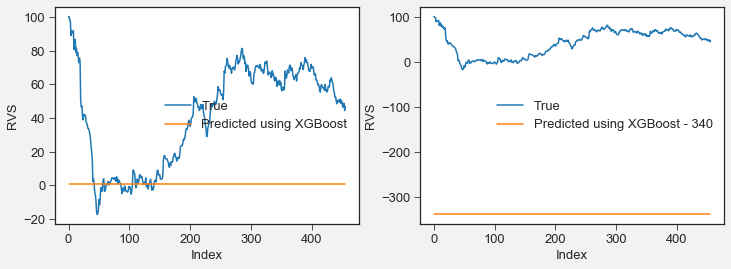

RMS = 50.602


In [18]:
model = xgb.XGBRegressor(eta = BayesianOptimization.max["params"]["eta"],
                          max_depth =int(BayesianOptimization.max["params"]["max_depth"]),
                          num_round = int(BayesianOptimization.max["params"]["num_round"]), 
                          random_state=42)

model.fit(X_train, y_train)

# make predictions for test data
y_pred_xg = model.predict(X_test)#+155

# evaluate predictions
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test,label="True")
plt.plot(y_pred_xg, label="Predicted using XGBoost")
plt.xlabel("Index"); plt.ylabel("RVS")
plt.legend(loc="center right")
plt.subplot(122)
plt.plot(y_test,label="True")
plt.plot(y_pred_xg -340, label="Predicted using XGBoost - 340")
plt.xlabel("Index"); plt.ylabel("RVS")
fig.patch.set_facecolor("#f2f2f2")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_xg)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

In [19]:
# fig.savefig(f"figs/bad_test_{test_on+1}_XGBoost.pdf", facecolor=fig.get_facecolor())

## NN

In [20]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [21]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


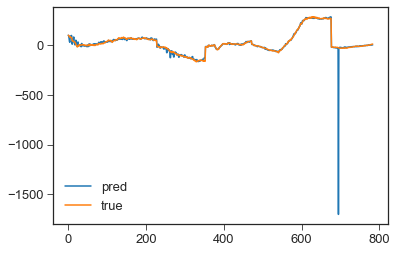

In [22]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [23]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.6s finished


In [24]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (24, 13, 5), 'learning_rate_init': 0.4401524937396013} , Best scores: -91.2264


34.07371018246099


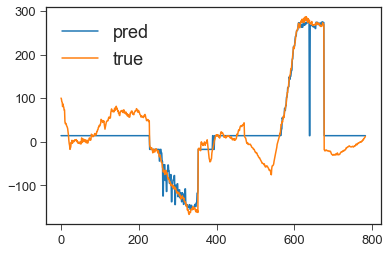

In [25]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend(fontsize=(18))
plt.show()

### Predict one timeseries

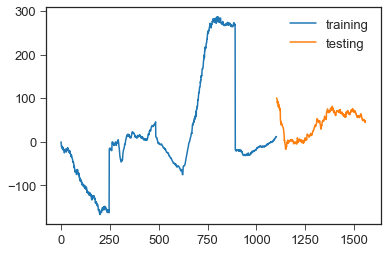

In [26]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=scale)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Remove to only 2 features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]

# Plot
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [27]:
seed = 591
np.random.seed(seed)
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000, random_state=seed)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Test
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000, random_state=seed)
ind = np.arange(0, X_train.shape[0], 1)
np.random.shuffle(ind)
X_train2 = X_train[ind, :]
print(X_train.shape, X_train2.shape)
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000)
mlp.fit(X_train2, y_train)

y_pred_other = mlp.predict(X_test)

(1103, 25) (1103, 25)


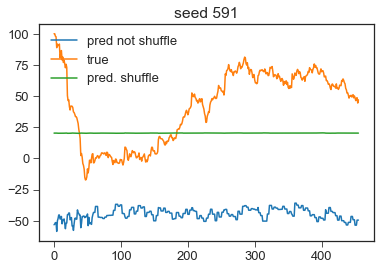

In [28]:
# Plotting
plt.figure()
plt.title(f"seed {seed}")
plt.plot(y_pred,label="pred not shuffle")
plt.plot(y_test, label="true")
plt.plot(y_pred_other, label="pred. shuffle")
plt.legend()
plt.show()

### CV

In [29]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform(),
#     "max_iter": st.randint(100,1000)
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.6s finished


In [30]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (17, 14, 6), 'learning_rate_init': 0.8948273504276488} , Best scores: -94.6964


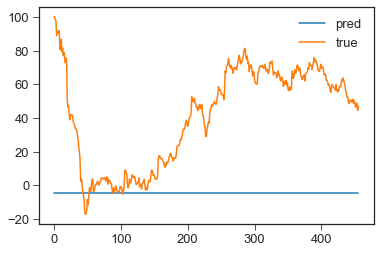

In [31]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### Bayesian optimization NN

In [39]:
from bayes_opt import BayesianOptimization
def NN_CrossValidation(learning_rate_init, nodes_1, nodes_2, data, targets):
    '''nodes contain the given number of nodes in the given layer'''
    estimator = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000,
                             learning_rate_init=learning_rate_init,
                             hidden_layer_sizes = (nodes_1, nodes_2))
    
    cval = cross_val_score(estimator, data, targets, cv=5, scoring = 'neg_root_mean_squared_error')
    
    return cval.mean()

def optimize_NN(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate_init, nodes_1, nodes_2, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return NN_CrossValidation(learning_rate_init=learning_rate_init, 
                                       nodes_1 = int(nodes_1),
                                       nodes_2 = int(nodes_2),
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [40]:
parameters_BayesianOptimization = {"learning_rate_init": (0.0001, 1), 
                                   "nodes_1": (1, 100),
                                   "nodes_2": (1, 100)
                                  }

BayesianOptimization = optimize_NN(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=100)
print(BayesianOptimization.max)

|   iter    |  target   | learni... |  nodes_1  |  nodes_2  |
-------------------------------------------------------------
|  1        | -107.8    |  0.3746   |  95.12    |  73.47    |
|  2        | -111.9    |  0.5987   |  16.45    |  16.44    |
|  3        | -144.7    |  0.05818  |  86.75    |  60.51    |
|  4        | -118.7    |  0.7081   |  3.038    |  97.02    |
|  5        | -111.3    |  0.7824   |  3.282    |  96.97    |
|  6        | -120.4    |  0.8255   |  2.825    |  97.07    |
|  7        | -104.6    |  0.5623   |  3.439    |  96.85    |
|  8        | -114.7    |  0.5823   |  16.73    |  16.38    |
|  9        | -114.7    |  0.5763   |  16.43    |  16.3     |
|  10       | -110.3    |  0.6027   |  3.432    |  96.86    |
|  11       | -125.1    |  0.2695   |  16.68    |  16.53    |
|  12       | -120.1    |  0.03597  |  94.81    |  73.47    |
|  13       | -111.8    |  0.8519   |  3.682    |  96.96    |
|  14       | -118.7    |  0.04096  |  49.4     |  59.57    |
|  15   

|  80       | -104.1    |  0.926    |  83.06    |  42.9     |
|  81       | -119.3    |  0.1015   |  51.9     |  53.47    |
|  82       | -117.4    |  0.4054   |  22.74    |  93.77    |
|  83       | -112.9    |  0.9337   |  13.25    |  98.07    |
|  84       | -112.5    |  0.7515   |  94.98    |  73.09    |
|  85       | -101.5    |  0.8825   |  51.68    |  5.857    |
|  86       | -96.32    |  0.8782   |  58.08    |  30.6     |
|  87       | -109.4    |  0.7289   |  22.95    |  30.58    |
|  88       | -116.6    |  0.568    |  37.68    |  60.96    |
|  89       | -104.2    |  0.121    |  94.4     |  92.63    |
|  90       | -113.0    |  0.9156   |  13.86    |  52.3     |
|  91       | -110.8    |  0.6921   |  23.19    |  21.33    |
|  92       | -107.0    |  0.824    |  11.96    |  22.52    |
|  93       | -115.9    |  0.505    |  1.785    |  82.87    |
|  94       | -102.1    |  0.9346   |  22.66    |  21.44    |
|  95       | -101.9    |  0.6865   |  51.59    |  5.822    |
|  96   

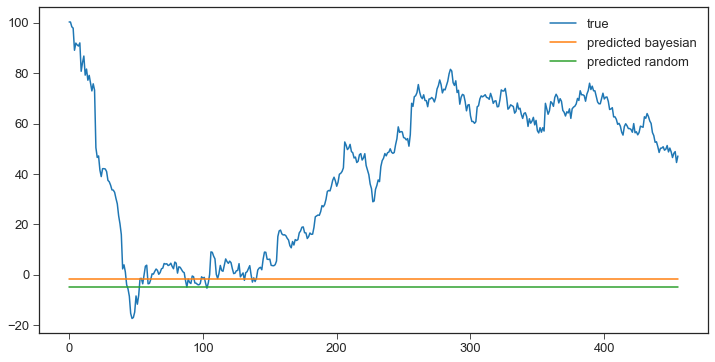

RMS = 52.431


In [41]:
model = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True,
                         learning_rate_init=BayesianOptimization.max["params"]["learning_rate_init"],
                         hidden_layer_sizes = (int(BayesianOptimization.max["params"]["nodes_1"]), 
                                               int(BayesianOptimization.max["params"]["nodes_2"]))
                    )
model.fit(X_train, y_train)

# make predictions for test data
y_pred_mlp = model.predict(X_test)

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred_mlp, label="predicted bayesian")
plt.plot(y_pred, label="predicted random")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_mlp)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## Linear Regression

In [35]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)

In [36]:
LSTM_res = np.loadtxt("LSTM_predicted.txt")

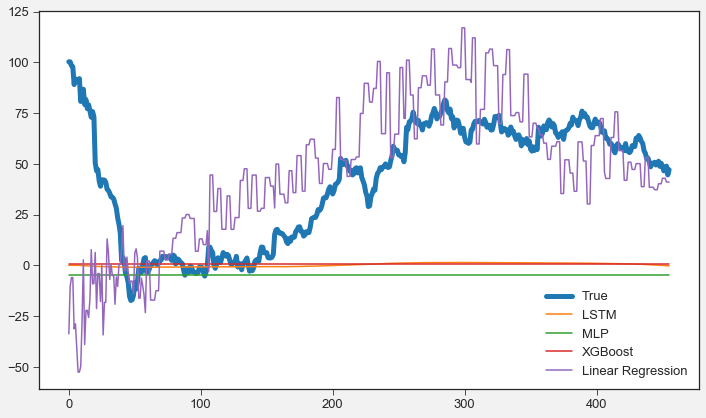

In [42]:
fig = plt.figure(figsize=(10,6))
plt.plot(y_test, label="True", lw=5.)
plt.plot(LSTM_res,label="LSTM")
plt.plot(y_pred, label="MLP")
plt.plot(y_pred_xg, label="XGBoost")
plt.plot(y_pred_linear- 750, label="Linear Regression")
fig.patch.set_facecolor("#f2f2f2")
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/Final_result_test_on_{test_on}.png", dpi=500, facecolor=fig.get_facecolor())

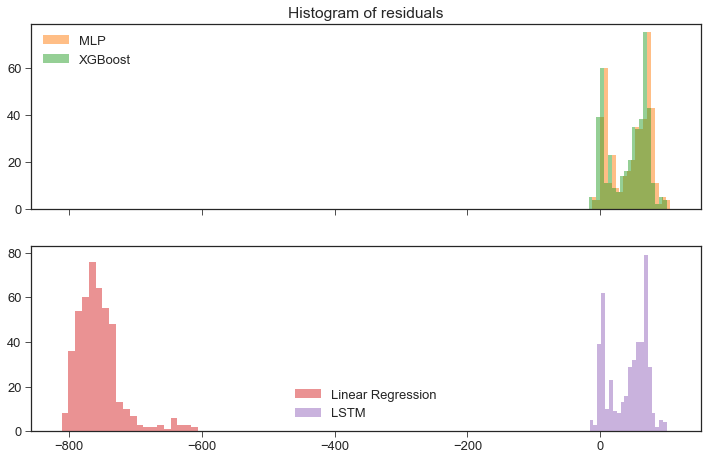

In [38]:
fig, axes = plt.subplots(2,1, figsize=(12,7.5), sharex=True)
ax = axes[0]
ax.set_title("Histogram of residuals")
ax.hist(y_test - y_pred, bins=20, label="MLP", alpha=.5, color="C1")
ax.hist(y_test - y_pred_xg, bins=20, label="XGBoost", alpha=.5, color="C2")
ax.legend()
ax = axes[1]
ax.hist(y_test - y_pred_linear, bins=20, label="Linear Regression",alpha=.5, color="C3")
ax.hist(y_test - LSTM_res, bins=20, label="LSTM", alpha=.5, color="C4")
ax.legend()
plt.show()